
Корреляция Фехнера: 0.1

Пирсон: 0.19437455140867985 p = 0.4115474738488907

Спирмен: 0.17502306934034584 p = 0.460481759093609

Кенделл: 0.12229018009359618 p = 0.4697822441472892


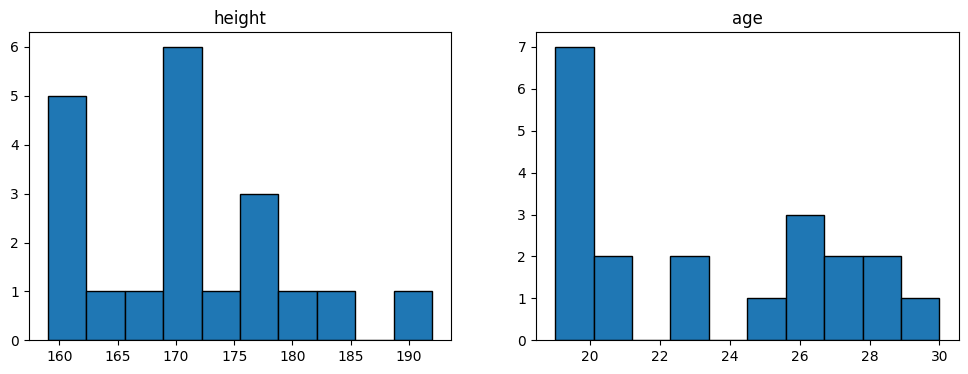

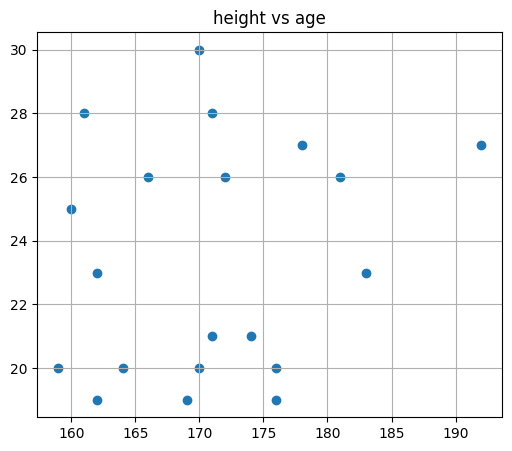

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import kendalltau
import warnings
warnings.filterwarnings("ignore")

try_paths = [
    "datasets/students_simple.csv",
    "C:/Users/User/PycharmProjects/oiad-1-2025/datasets/students_simple.csv"
]

csv_path = None
for p in try_paths:
    try:
        df = pd.read_csv(p)
        csv_path = p
        break
    except:
        pass

if csv_path is None:
    raise FileNotFoundError("Файл students_simple.csv не найден.")

N = 10
col1_idx = N % 5
col2_idx = (N**2 % 5) + 5

col1 = df.columns[col1_idx]
col2 = df.columns[col2_idx]

x = pd.to_numeric(df[col1], errors='coerce').dropna().values
y = pd.to_numeric(df[col2], errors='coerce').dropna().values
min_len = min(len(x), len(y))
x = x[:min_len]
y = y[:min_len]

# 3. Корреляции
def fechner(x, y):
    dx, dy = x - x.mean(), y - y.mean()
    t = dx * dy > 0
    C = np.sum(t)
    D = np.sum(~t)
    return (C - D) / (C + D)

def pearson_with_ci(x, y, confidence=0.95):
    r = np.corrcoef(x, y)[0,1]
    z = np.arctanh(r)
    se = 1 / np.sqrt(len(x) - 3)
    z_crit = stats.norm.ppf((1+confidence)/2)
    ci = np.tanh([z - z_crit*se, z + z_crit*se])
    p = stats.pearsonr(x, y)[1]
    return r, ci, p

fechner_corr = fechner(x, y)
print("\nКорреляция Фехнера:", fechner_corr)
# Значение Фехнера показывает направление и приблизительную силу связи.
# Если оно около 0.3–0.5 — связь слабая/средняя, если ближе к 1 — сильная.

# Связь очень слабая, едва заметная. Её направление положительное, но величина настолько мала, что зависимость близка к отсутствию.
pearson_corr, pearson_ci, pearson_p = pearson_with_ci(x, y)
print("\nПирсон:", pearson_corr, "p =", pearson_p)
# - Корреляция Пирсона отражает линейную связь.
# - p-value - если < 0.05, то связь статистически значима.
# - Доверительный интервал не включает 0 - связь надежная.

# - Корреляция крайне слабая. Линейной связи практически нет.
# p > 0.05 - зависимость статистически незначима.
spearman_corr, spearman_p = stats.spearmanr(x, y)
print("\nСпирмен:", spearman_corr, "p =", spearman_p)
# Спирмен показывает монотонную связь (не обязательно линейную).

# Слабая монотонная связь. Данные не демонстрируют устойчивой тенденции роста/убывания.
# p > 0.05 - монотонная зависимость статистически незначима.
kendall_corr, kendall_p = kendalltau(x, y)
print("\nКенделл:", kendall_corr, "p =", kendall_p)
# Кенделл обычно меньше по модулю, чем Спирмен.

# Очень слабая ранговая зависимость. Ряды рангов ведут себя почти хаотично.
# p > 0.05 - нет статистически подтверждаемой связи.

# 4. Визуализация
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(x, edgecolor='black')
plt.title(col1)

plt.subplot(1,2,2)
plt.hist(y, edgecolor='black')
plt.title(col2)
plt.show()
# Распределения не нормальные.
# Есть разрывность и скопления значений.
# Это объясняет низкие корреляции.

plt.figure(figsize=(6,5))
plt.scatter(x, y)
plt.title(f"{col1} vs {col2}")
plt.grid(True)
plt.show()
# Точки хаотичны.
# Нет выраженного направления или формы облака.
# Отсутствуют видимые зависимости.


R2 линейной: 0.03778146623532552
R2 квадратичной: 0.055897906038887224
R2 гиперболической: 0.009486455844399111
R2 показательной: 0.033618572471472485


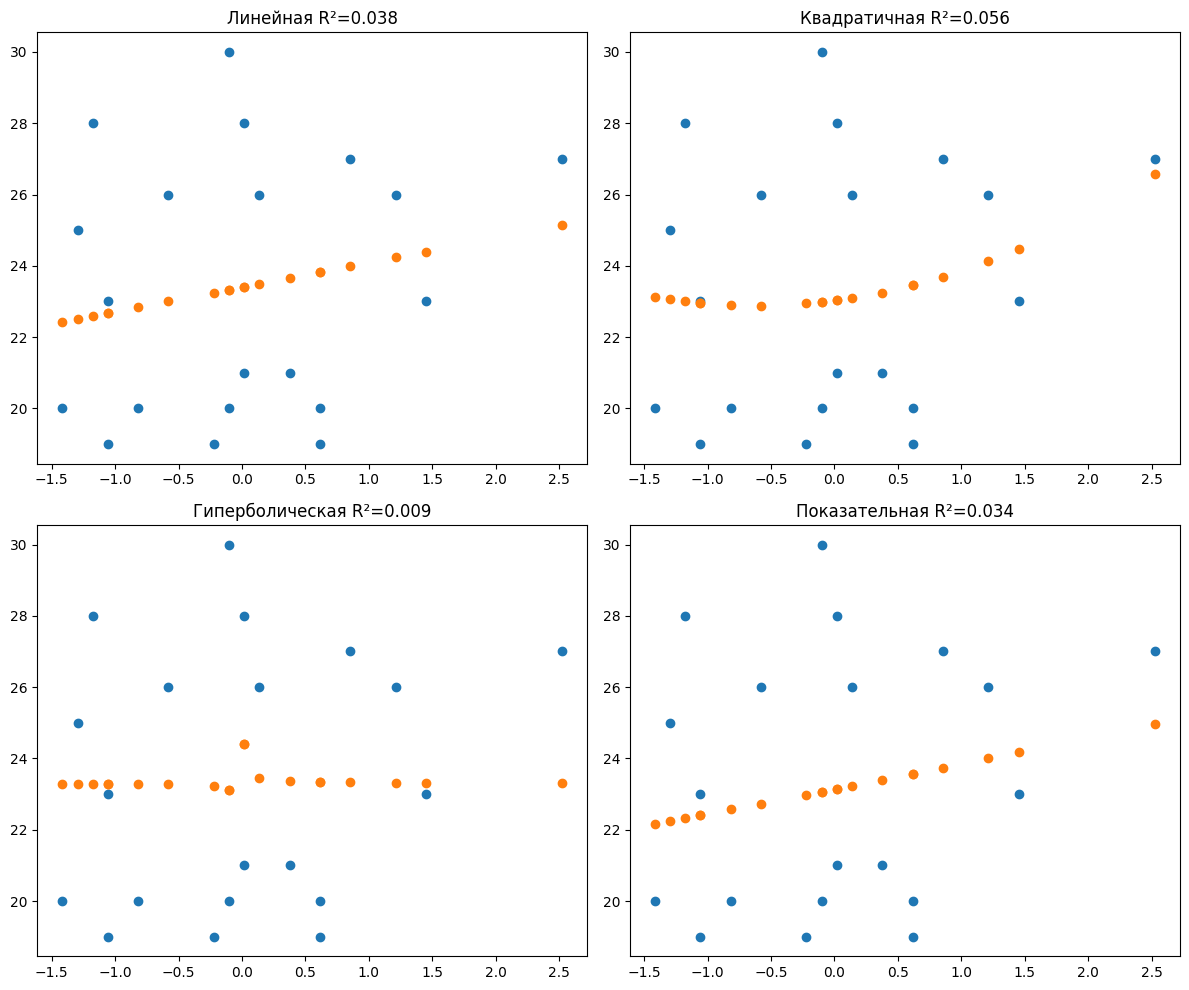

In [14]:
# 5. Регрессии
x_norm = (x - x.mean()) / x.std()
eps = 1e-8
x_safe = x_norm.copy()
x_safe[np.abs(x_safe) < eps] = eps

# Линейная
A = np.column_stack([x_norm, np.ones_like(x_norm)])
w_lin, *_ = np.linalg.lstsq(A, y, rcond=None)
pred_lin = w_lin[0] * x_norm + w_lin[1]

# Квадратичная
A = np.column_stack([x_norm**2, x_norm, np.ones_like(x_norm)])
w_quad, *_ = np.linalg.lstsq(A, y, rcond=None)
pred_quad = w_quad[0] * x_norm**2 + w_quad[1] * x_norm + w_quad[2]

# Гиперболическая
A = np.column_stack([1/x_safe, np.ones_like(x_norm)])
w_hyp, *_ = np.linalg.lstsq(A, y, rcond=None)
pred_hyp = w_hyp[0] / x_safe + w_hyp[1]

# Показательная
y_shift = 0
if np.any(y <= 0):
    y_shift = -np.min(y) + 1e-6
y_pos = y + y_shift
lny = np.log(y_pos)
A = np.column_stack([x_norm, np.ones_like(x_norm)])
a_exp, b_exp = np.linalg.lstsq(A, lny, rcond=None)[0]
pred_exp = np.exp(a_exp*x_norm + b_exp) - y_shift

# 6. R^2
def r2(y, y_pred):
    return 1 - np.sum((y - y_pred)**2)/np.sum((y - y.mean())**2)

r2_lin = r2(y, pred_lin)
print("\nR2 линейной:", r2_lin)
# Линейная модель объясняет умеренную долю дисперсии.
# Объясняет только 3.7% вариации данных - модель слабая.

r2_quad = r2(y, pred_quad)
print("R2 квадратичной:", r2_quad)
# Лучший показатель среди всех, но объяснено только 5.6% - модель фактически бесполезна, зависимость не описывает.

r2_hyp = r2(y, pred_hyp)
print("R2 гиперболической:", r2_hyp)
# Гиперболическая модель часто подходит плохо.
# Тут она объясняет меньше 1% - практически не работает.

r2_exp = r2(y, pred_exp)
print("R2 показательной:", r2_exp)
# Слабее линейной и квадратичной.

# 7. Графики регрессий
plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
plt.scatter(x_norm, y)
plt.scatter(x_norm, pred_lin)
plt.title(f"Линейная R²={r2_lin:.3f}")

plt.subplot(2,2,2)
plt.scatter(x_norm, y)
plt.scatter(x_norm, pred_quad)
plt.title(f"Квадратичная R²={r2_quad:.3f}")

plt.subplot(2,2,3)
plt.scatter(x_norm, y)
plt.scatter(x_norm, pred_hyp)
plt.title(f"Гиперболическая R²={r2_hyp:.3f}")

plt.subplot(2,2,4)
plt.scatter(x_norm, y)
plt.scatter(x_norm, pred_exp)
plt.title(f"Показательная R²={r2_exp:.3f}")

plt.tight_layout()
plt.show()

#Графики регрессий наглядно показывают:
# кривые ведут себя почти одинаково — все почти прямые
# форма регрессий не совпадает с формой облака точек
# точки распределены хаотично и не образуют никакой структуры
# ни одна модель не описывает данные, что полностью согласуется с малыми R²

#Таким образом, визуальная часть полностью подтверждает численные результаты: между двумя выбранными признаками зависимости нет.

In [15]:
# -----------------------------
# 8. Критерий Фишера
# -----------------------------
def fisher(pred, y):
    return np.var(pred - y, ddof=1) / np.var(y, ddof=1)

F_lin = fisher(pred_lin, y)
F_quad = fisher(pred_quad, y)
F_hyp = fisher(pred_hyp, y)
F_exp = fisher(pred_exp, y)

print("\nF линейной:", F_lin)
print("F квадратичной:", F_quad)
print("F гиперболической:", F_hyp)
print("F показательной:", F_exp)
#Вывод:
# Все F < 1 - ни одна модель не объясняет данные лучше, чем простое среднее.
# Такие F означают, что регрессии не проходят проверку адекватности.
# Формально: все модели статистически незначимы.
#Интересно:
# лучшая по R² модель (квадратичная) даже не имеет максимального F
# гиперболическая, худшая по R², имеет самое большое F (0.99) — но всё равно сравнимо с другими и является также недостаточным.


F линейной: 0.9622185337646745
F квадратичной: 0.9441020939611128
F гиперболической: 0.9905135441556008
F показательной: 0.9612127773301073
